<a href="https://colab.research.google.com/github/weymouth/MarineHydro/blob/master/notebooks/water_waves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numerical potential flow water waves 🌊

The goal of this notebook is to compute the potential flow and forces on a body in waves, but let's start with a recap. 

Recall from [the first notebook](https://github.com/weymouth/MarineHydro/blob/master/notebooks/panel_method.ipynb) that the scaled potential $\phi_k$ due to motion in degree of freedom $k$ is defined as a superposition of the contributions from each panel $i$

$$\phi_k = \sum_i q_{k,i} F_i^\phi \quad\text{where}\quad F_i^\phi=\int_{s_i}^{s_{i+1}} G(s) ds $$

where $q_{k,i}$ is the panel *strength* and $G$ is the panel *Green's function*. Once the strength's are set to satisfy the body boundary condition, $\phi_k$ determines the whole flow and the added mass matrix.

The first notebook developed a numerical method to compute this potential around any submerged 2D geometry using a potential flow source as the Green's function, as well as code to plot the flow and compute the added mass. Those functions are collected in [this source file](https://github.com/weymouth/MarineHydro/blob/master/src/PanelMethod.py) which we can execute using the [requests package](https://anaconda.org/anaconda/requests).

In [1]:
import requests
url = 'https://raw.githubusercontent.com/weymouth/MarineHydro/master/src/PanelMethod.py'
exec(requests.get(url).content)

## Free surface Greens Function💧+👋=🌊

In this notebook we will consider the oscillation of a body near the free surface, with displacement 

$$\xi_k = |\xi_k|\cos\omega t$$

where $|\xi_k|,\omega$ are the amplitude and frequency of motion.

This motions near the free surface will generate waves, changing the flow and forces significantly compared to the case considered in the first notebook. Despite the huge change to the physical set-up and results, we only need to make a *single modification* to the numerical method:

**We need to modify the source Green's function $G$ to include the potential flow waves which it generates. That's it!**  

Here is new the Green's function, taken from [this modern paper](https://www.researchgate.net/profile/Ed-Mackay/publication/344610701_Calculation_of_the_two-dimensional_free_surface_Green_function/links/5f84519f299bf1b53e20e1f2/Calculation-of-the-two-dimensional-free-surface-Green-function.pdf):

$$ G(x,y,x_s,y_s) = \log(r_s)-2\pi \imath e^Z-f(Z) $$

There are three terms:

1. The first term is the **oscillating source** where $r_s^2 = (x-x_s)^2+(y-y_s)^2$ is the square-distance from the point $(x_s,y_s)$ on the segment to a point $(x,y)$ in space, as before. As in the first notebook, the Green's function only includes the spacial dependence, the source strength and the oscillation time dependance are multiplied later.

2. The second term is the **traveling wave** written using complex variables. The standard wave potential is 
$$ \phi = \frac{ag}{\omega} e^{Ky}\cos(Kx-\omega t+\Phi) $$
where $a,\Phi$ are the wave amplitude and the phase relative to the motion, and $K=\omega^2/g$ is the deep water wave number. In complex variables we have $e^{\imath\theta} = \cos\theta+\imath\sin\theta$, where $\imath=\sqrt{-1}$. Therefore we can write
$$ \phi = \Re\left[\underbrace{\zeta e^{K(y+\imath x)}}_\text{space} \underbrace{e^{-\imath\omega t}}_\text{time}\right] $$
where $\zeta$ is the *complex* amplitude which includes the phase. The traveling wave term in $G$ matches the spacial part of this potential using $Z=K(y+y_s+\imath(x-x_s))$ (shifting the origin of the wave) and setting $\zeta=-2\pi\imath$. 

3. Finally, the last term is a **standing wave** potential which is added to the source potential so that the total satisfies the free surface boundary condition 
$$ K\phi-\frac{\partial\phi}{\partial y} = 0 \quad\text{on}\quad y=0$$

Let's look at the velocity field induced by a single source panel near the free surface.

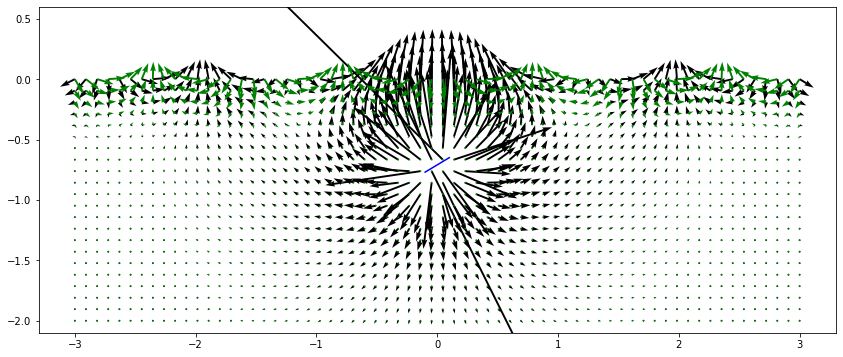

In [2]:
from scipy.special import exp1

def wave_source(x, y, xs, ys, K):
    "Source plus generated free surface waves"
    r2 = (x-xs)**2 + (y-ys)**2     # source square-distance
    Z = K*(y+ys + 1j*abs(x-xs))  # wave number scaled complex vector
    eZ = np.exp(Z)                 # traveling wave potential
    fZ = 2*np.real(eZ*exp1(Z)) + np.log(np.abs(Z)/K)   # standing wave potential
    return 0.5*np.log(r2) - 2j*np.pi*eZ - fZ

XY = np.meshgrid(np.linspace(-3,3,66), np.linspace(-2,0,22))
K = 4

plot_flow([-.1,.1], [-.77,-0.65], [1], XY,wave_source, (K,), size=(16,6), ymax=0.6)

We can clearly see the source and the waves above, but why are there *two* sets of vector fields and what do they mean? 

The Green's function is now complex, which makes the potential $\phi_k$ and the velocity complex as well. These complex numbers are storing the **phase** information, just like the complex wave amplitude discussed above. 
 - The black arrows are the real part. As $\Re[e^{\imath\omega t}]=\cos\omega t$ these are *in-phase* with the panel displacement $\xi_k$ and the acceleration $\ddot\xi_k$ which are both $\cos$ terms. 
 - The green arrows are the imaginary part. As $\Im[e^{\imath\omega t}]=\sin\omega t$ these are *out-of-phase* with the panel displacement, instead being in-phase with the velocity $\dot\xi_k$.

This is easier to understand using a movie!

> **Note:** It takes a while for Python to generate the videos, so I've commented those lines out. Uncomment and play around with the flows in the following cells as much as you like.

In [3]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def wave_video(x, y, q, XY, G=wave_source, args=(4,), size=(16,6)):
    # Get complex velocity
    def uv(i): return q[i]*velocity(*XY, x[i], y[i], x[i+1], y[i+1], G, args)
    UV = sum(uv(i) for i in range(len(x)-1))

    # Plot flow and segments
    fig, ax = plt.subplots(1, 1, figsize=size)
    Q = ax.quiver(*XY, *UV)#, pivot='mid')
    ax.plot(x, y, c='b')
    ax.set_ylim(None, 0.5)
    ax.set_aspect('equal', adjustable='box')
    plt.close()

    # run through a wave period and take the real part
    def update_quiver(num, Q):
        Q.set_UVC(*np.real(UV*np.exp(-2j*np.pi*num/101)))
        return Q,

    # create the animation
    return FuncAnimation(fig, update_quiver, fargs=(Q,), interval=50)

# anim = wave_video([-.1,.1],[-.77,-0.65],[1],XY)
# HTML(anim.to_html5_video())

[![Link to video](http://i3.ytimg.com/vi/3DSdek0stHM/hqdefault.jpg)](https://youtu.be/3DSdek0stHM)

Looks good. The source, standing wave above it, and the radiating waves on either side are all visible. 

> **Note:** Now that you've seen the video, go back and look at the plot above. The black and green arrows are snapshots of the video at the start and a quarter of the way through a cycle. While the movie is certainly easier to digest, it's important to realize the scaled potential $\phi_k$ has all the information needed to make the movie.

---

## Solving for free surface potential flows and forces 🛥

> **Note:** The plots above use the original `velocity` function, they just apply the new `wave_source` singularity instead of the `source` singularity. Similarly, the `potential`, `construct_A` and `added_mass` functions can all by applied to free surface flows without modification!

This is why writing re-usable functions is so powerful. Let's use our new Green's function to produce the flow around a semi-circular ship section in sway.

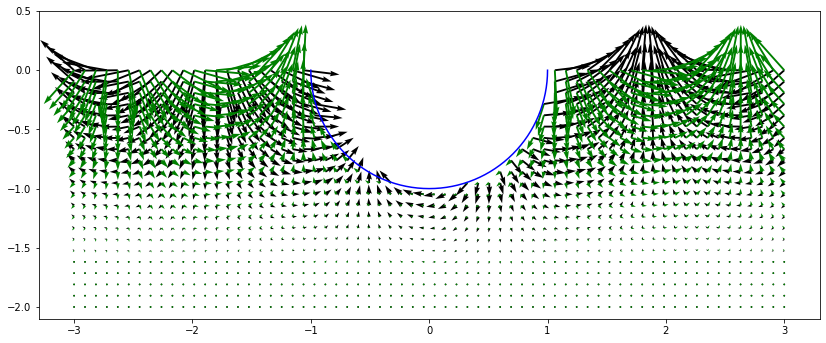

In [4]:
x, y = ellipse(64, theta1=0)
circleXY = mask_grid(*XY, mask=lambda x,y: x**2 + y**2 < 1)
K = 2
A, nx, ny = construct_A(x, y, wave_source, (K,))
plot_flow(x, y, np.linalg.solve(A,nx), circleXY, wave_source, (K,), size=(14,6), ymax=0.5)
# anim = wave_video(x,y,np.linalg.solve(A,nx),circleXY,wave_source,(K,))
# HTML(anim.to_html5_video())

That's amazing! You can clearly see the waves radiating away from the ship hull in either direction. When the ship moves to port, it forms a new crest on the port side, and vice-versa!

Now let's check the added mass:

In [5]:
ma = added_mass(x, y, wave_source, (K,))
print(np.array_str(ma, precision=3, suppress_small=True))

[[ 0.294+0.608j -0.   -0.j   ]
 [-0.   -0.j     1.135+0.197j]]


Look carefully at this result because two important things have changed since we moved into free surface flows
1. **The matrix is complex!** The real part $A_{kl}=\Re(m_{kl})$ is the added mass in-phase with acceleration and the imaginary part $B_{kl}=\omega\Im(m_{kl})$ is the wave damping in-phase with velocity, such that the total force is now $$ f_l = \sum_k \ddot\xi_k A_{kl}+\dot\xi_k B_{kl}.$$ The damping is due to energy leaving the system in the radiating waves, which is why the damping is always zero when there is no free surface. 
1. **The values depend on the wave number!** A fully submerged circle of radius $R$ has $m_{kk}=\rho \pi R^2$ independent of the oscillation frequency, and this independance is true for any fully submerged shape. But the free surface Green's function depends on $K$, and so the resulting potential and matrix does as well!

You can test this by changing the value of $K$ above and you will see a huge variation. Below, I have plotted the *dimensionless* added-mass and damping coefficients for a range of dimensionless frequencies $\omega \sqrt{R/g}=\sqrt{KR}$.

> **Note:** We've switched to a section in the $y,z$ plane since this is standard for strip theory.

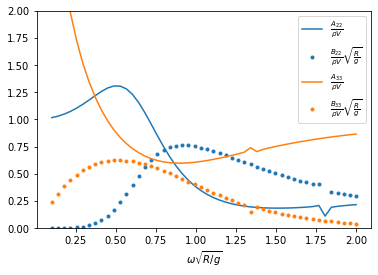

In [6]:
def force_plots(y, z, omega, rhoV=0.5*np.pi):
    @np.vectorize
    def force_coeffs(omega):
        Ca = added_mass(y, z, wave_source, (omega**2,))/rhoV
        return Ca[0,0].real,omega*Ca[0,0].imag,Ca[1,1].real,omega*Ca[1,1].imag

    A22,B22,A33,B33 = force_coeffs(omega)
    plt.plot(omega,A22,'C0',label=r'$\frac{A_{22}}{\rho V}$')
    plt.plot(omega,B22,'C0.',label=r'$\frac{B_{22}}{\rho V}\sqrt{\frac{R}{g}}$')
    plt.plot(omega,A33,'C1',label=r'$\frac{A_{33}}{\rho V}$')
    plt.plot(omega,B33,'C1.',label=r'$\frac{B_{33}}{\rho V}\sqrt{\frac{R}{g}}$')
    plt.xlabel(r'$\omega\sqrt{R/g}$')
    plt.ylim(0, 2);plt.legend()

force_plots(*ellipse(64,theta1=0), np.linspace(0.1,2))

The added-mass predictions vary from 20% to 200% of the displacement! **But is this correct?**

> **Note:** You weren't going to trust this numerical method before it was validated... were you?

Here are some experimental and analytic results for the added mass and damping on a semi-circle from [Vugts 1968](https://content.iospress.com/download/international-shipbuilding-progress/isp15-167-02?id=international-shipbuilding-progress%2Fisp15-167-02). 

| Heave| Sway|
|-|-|
|![heave](https://drive.google.com/uc?export=view&id=1JYMgqOeW_UEGjXzq1VrbZ5_HQXsh3ayI) | ![sway](https://drive.google.com/uc?export=view&id=19P67Q0zPyW_yquO_37lOhHZEFMJlnNiV)|


Our results match the analytic results in the paper really well (other than at two special points that we will discuss in a moment). This validates our free surface numerical predictions!

The potential flow methods both match the experiments nicely other than the zero frequency heave added mass. The linear equations themselves are **invalid** in the limit of $\omega\rightarrow 0$, causing the discrepancy. 

---

## Wave resonance (😄)^💧=😅 

The two blips in our added mass prediction results are due to resonance *inside* the geometry!

> **Note:** These are the frequencies which could potentially cause issues with sloshing cargo.

The flow *inside* the hull is plotted below - showing an internal standing wave. This wave totally dominates the flow and causes a singularity in the added mass calculation. However, we're typically only interested in the forces caused by the flow external to the hull, meaning we can ignore these artifacts.

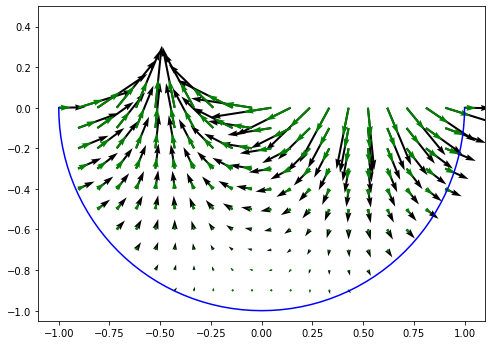

In [7]:
K = 3.25 # sway sloshing wavenumber from plot above
y, z = ellipse(64, theta1=0)
A, ny, nz = construct_A(y, z, wave_source, (K,))
YZ = np.meshgrid(np.linspace(-1,1,22), np.linspace(-1,0,11))
inside = mask_grid(*YZ, mask=lambda y,z: y**2+z**2>1)
plot_flow(y, z, np.linalg.solve(A, ny), inside, wave_source, (K,), size=(8,6), ymax=0.5)

# anim = wave_video(y,z,np.linalg.solve(A,ny),inside,wave_source,(K,),size=(8,6))
# HTML(anim.to_html5_video())

---

## Multiple geometries ⛵⛵

The functions above only compute the flow and forces around a single shape - they take in **one** pair of coordinate arrays `x,y`. How can we compute the flow induced by more than one shape, like a two boats in proximity or a multi-hull? Here are some ideas:

1. **Superposition:** Can we define the geometries, solve for each flow separately, and then add the flow and forces together? 

*No.* If we solve for the flows separately, we will miss the influence of the bodies on each other. When we add them up, the body BC won't be satisfied and so the flow and forces will be wrong.

2. **Images:** Can we apply the method of images to reflect the geometry across the $y$ axis?

*Yes... in some cases.* This is the classic approach (since it play nice with analytic models) but there are some caveats. Importantly, this only works when you have a plane of symmetry! So you can't use this to model two independent hulls - even if the geometries are identical, their motions won't be. It would also require using a new Green's function.

3. **Concatenation:** Can we stack all the body arrays together, and then solve for the flow?

*Yes... if we are careful.* This approach includes the influence of each body on the other, but it will also create fake panels linking the bodies together. We need to zero the influence of those "non-panels". This is the approach I've used below.

Sway added mass = 1.12+0.579j


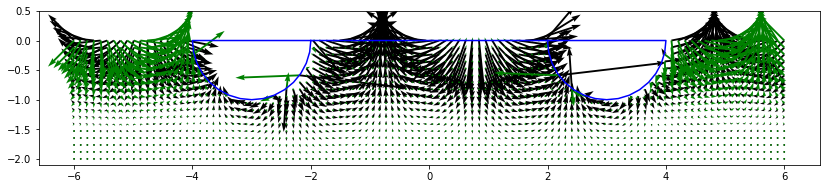

In [8]:
def circle_cat(N,gap):
    ya, za = ellipse(N//2, theta1=0)
    yb, zb = ellipse(N//2, theta1=0)
    return np.append(ya+gap, yb-gap), np.append(za, zb), [N//2]

def concat_sway(y,z,blank,G,args):
    yc, zc, ny, _, h = properties(y[:-1], z[:-1], y[1:], z[1:])
    A, ny, _ = construct_A(y, z, G, args)
    # *zero* the connecting panels before solving
    for i in blank:
        A[i,:] = np.zeros(len(ny)); A[i,i] = 1; ny[i] = 0
    qy = np.linalg.solve(A, ny) # sway source

    B = [h*potential(yc, zc, y[i], z[i], y[i+1], z[i+1], G, args) for i in range(len(yc))]
    myy = -ny@B@qy # sway added-mass
    return qy, myy

N, K, gap = 32, 2, 3
y, z, blank = circle_cat(N, gap)
catYZ = np.meshgrid(np.linspace(-6,6,108), np.linspace(-2,0,18))
catYZ = mask_grid(*catYZ, mask=lambda y,z: (abs(y)-gap)**2 + z**2<1)
qy, myy = concat_sway(y, z, blank,wave_source, (K,))
print(f'Sway added mass = {myy:.3g}')
plot_flow(y, z, qy, catYZ, wave_source, (K,), size=(14,6), ymax=0.5)

Look at the wave in the center of the plot, between the two circles. Since the arrows are all black instead of green, this is a standing wave caught between the hulls. As with the *internal* wave mentioned above, this *external* standing wave will also produce large forces and we therefore need to be careful to consider it's impact on multi-hull performance. 

---

## Parametric study 🧑‍💻 📈

We will run a geometric parameter sweep on the distance between the centers $Y$=2`gap` to investigate the impact of the geometry and on the forces.

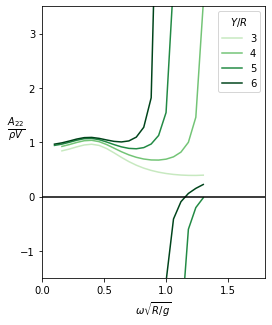

In [9]:
@np.vectorize
def sway(omega, gap, rhoV=np.pi):
    y, z, blank = circle_cat(32, gap)
    _ , ma = concat_sway(y, z, blank, wave_source, (omega**2,))
    return np.real(ma/rhoV)

def myplot(x,y,label,**kwargs): # remove segment connecting +/- singularities
    i = np.argmax(np.diff(y) < -4) + 1
    plt.plot(x[:i], y[:i], label=label, **kwargs)
    plt.plot(x[i:], y[i:], **kwargs)

omega = np.linspace(0.1, 1.3, 21)
plt.figure(figsize=(4, 5))
for Y in range(3, 7):
  myplot(omega, sway(omega, Y/2), label=Y, color=plt.cm.Greens((Y-2)/4))
plt.legend(title=r'$Y/R$')
plt.axhline(y=0, c='k')
plt.xlabel(r'$\omega\sqrt{R/g}$')
plt.ylabel(r'$\frac{A_{22}}{\rho V}$', rotation=0, size=14)
plt.ylim(-1.5, 3.5)
plt.xlim(0, 1.8);

This plot (formatted to match the figure in Faltisen) shows that the resonant standing wave between the hulls causes a singularity in the linear added-mass. As before, the singularity indicates a breakdown of linear theory but there will still be very large (positive *or negative*) added mass near this frequency.

> **Note**: The resonant frequency decreases as the gap is increased, corresponding to the longer wavelength of the standing wave. Building a cat with a spacing similar to the dominant water wavelength in a region would lead to serious sea keeping and stability issues.

---


## Summary 🏁 🏁

That's it for the second notebook. Let's review the main takeaway points:
 1. To solve for potential flows with a free surface, we **only** need to modify the Green's function to include the surface wave potential induced by the source. No other changes are needed to any of the functions from the previous notebook!
 2. The wave potential, and therefore the flow solutions and forces, inherently **depends on the oscillation frequency** because of the free surface boundary conditions. 
 3. In addition to the added-mass force in phase with body acceleration, there is also a **wave damping force** in phase with the body velocity which carries energy away from the body.
 4. The forces may vary drastically with frequency, particularly near resonance. Internal or external **standing waves** cause singularities in the force.
 5. A **parametric study** sweeps over one or more nondimensional parameters of interest such as a geometric ratio, and can provide important insights into a marine design. 